In [2]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim
from importlib import reload

In [3]:
## Summary of high-frequency, high-fitness barcodes 
reload(shared)
expt = 'E1'
fit_barcodes = {}
mouse_specific_high_frequency_barcodes = {}

mice_in_each_col = [(1,2,3,4,5), (6,7,8,9,10), (11,12,13)]
init_day, fin_day = 9, 15

SD_growth_rates = {}
MD_growth_rates = {}
for col, (m_set, colors, title) in enumerate( zip(mice_in_each_col, ['Blues', 'Oranges', 'Reds'], ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    for single_mouse in m_set:
        large_indices = shared.find_large_barcodes(expt, [single_mouse], max_cutoff=1e-2, final_cutoff=1)
        mouse_specific_high_frequency_barcodes[single_mouse] = large_indices
        #### record high frequency barcodes in each mouse
        for barcode in shared.barcodes[large_indices]:
            if barcode not in fit_barcodes:
                fit_barcodes[barcode] = []
            fit_barcodes[barcode].append(single_mouse)

        ### estimate exponential growth rates
        if single_mouse in [4,5,6,7]:  ###  exclude cross-housed mice
            continue
        if single_mouse in [1,2,3,8,9,10]:
            diet_growth_rates = SD_growth_rates
        elif single_mouse in [11,12,13]:
            diet_growth_rates = MD_growth_rates


        # days, rows, cec = shared.mouse_meta[expt][single_mouse]
        # freqs, Deff = shared.freq_array[rows], shared.Deff_array[rows]

        days, reads, depths = shared.get_mouse_timecourse(expt, single_mouse, min_depth=10**3)
        freqs = shared.calc_freqs(reads, depths)


        # fig, ax = plt.subplots()
        for barcode_idx in large_indices:
            barcode = shared.barcodes[barcode_idx]
            bc_freqs = freqs[:,barcode_idx]
            
            final_idx = np.where(bc_freqs > 10**-2)[0][0]
            try:
                init_idx = np.where(bc_freqs[:final_idx] < 10**-3)[0][-1]
            except:
                init_idx = 0

            t0, t1 = days[init_idx], days[final_idx]
            if t1 > 21:
                continue
            dt = t1-t0

            _, reads, [D0, D1] = shared.get_mouse_timecourse(expt, single_mouse, specific_timepoints=[t0, t1])
            f0,f1 = shared.calc_freqs(reads, np.array([D0, D1]))
            mm_f0, mm_f1 = shared.maxmin_freqs([f0[barcode_idx]], D0, [f1[barcode_idx]], D1)

            growth_rate = np.log(mm_f1/mm_f0)[0]/dt
            if barcode not in diet_growth_rates:
                diet_growth_rates[barcode] = []
            diet_growth_rates[barcode].append((single_mouse, growth_rate, (t0,t1), (f0*D0,f1*D1)))
            
        #     if growth_rate > 1:
        #         ax.plot(days, bc_freqs)
        # # ax.set_yscale('log')

SD_lst, MD_lst = [], []
for (diet, filtered_lst, diet_growth_rates) in [('SD', SD_lst, SD_growth_rates), ('MD', MD_lst, MD_growth_rates)]:
    for b, (barcode, bc_growths) in enumerate(diet_growth_rates.items()):
        growth_rates = np.array([g[1] for g in bc_growths]) 
        if len(growth_rates) == 0: continue
        filtered_lst.append(np.median(growth_rates)) # append the smallest fitness, for barcodes with estimates in multiple mice


    print(f'Diet {diet}: num_high_freq barcodes (>1%):', len(filtered_lst))
    print('List of growth rates:', [float(f'{g:.2f}') for g in filtered_lst])
    print('Min, max growth rate in first 3 weeks (/day):', f'{np.min(filtered_lst):.2f}, {np.max(filtered_lst):.2f}')
    print('25th, median, 75th percentile:', f'{np.percentile(filtered_lst, 25):.2f}, {np.median(filtered_lst):.2f}, {np.percentile(filtered_lst, 75):.2f}')
    print('\n')

MD_lst, SD_lst = np.array(MD_lst), np.array(SD_lst)
print('1-sided Mann Whitney test for MD > SD growths', scipy.stats.mannwhitneyu(MD_lst, SD_lst, alternative='greater'))

for mouse in mouse_specific_high_frequency_barcodes:
    print(f'Mouse {mouse}: {len(mouse_specific_high_frequency_barcodes[mouse])} high frequency barcodes')
    print('List of barcodes:', [shared.barcodes[b] for b in mouse_specific_high_frequency_barcodes[mouse]])


Diet SD: num_high_freq barcodes (>1%): 65
List of growth rates: [0.22, 0.48, 2.19, 0.16, 0.73, 0.28, 0.64, 0.42, 0.46, 0.48, 0.61, 0.31, 1.34, 0.17, 1.16, 0.2, 0.23, 0.45, 1.07, 0.38, 0.27, 0.17, 0.24, 0.24, 0.37, 0.18, 0.24, 0.26, 0.49, 0.4, 0.84, 0.49, 3.58, 0.22, 0.64, 0.83, 0.6, 1.1, 0.86, 0.38, 0.23, 0.26, 0.25, 0.86, 0.33, 0.96, 0.97, 0.37, 0.97, 0.96, 0.15, 0.61, 0.83, 0.24, 0.73, 0.32, 0.34, 0.59, 0.32, 1.29, 0.31, 1.24, 0.59, 1.1, 0.25]
Min, max growth rate in first 3 weeks (/day): 0.15, 3.58
25th, median, 75th percentile: 0.26, 0.45, 0.83


Diet MD: num_high_freq barcodes (>1%): 21
List of growth rates: [2.5, 0.74, 1.59, 1.98, 0.71, 1.79, 1.09, 1.19, 1.07, 1.73, 1.66, 4.26, 2.69, 1.55, 0.99, 2.25, 0.89, 0.22, 0.58, 0.71, 0.84]
Min, max growth rate in first 3 weeks (/day): 0.22, 4.26
25th, median, 75th percentile: 0.84, 1.19, 1.79


1-sided Mann Whitney test for MD > SD growths MannwhitneyuResult(statistic=1147.0, pvalue=1.548655944824145e-06)
Mouse 1: 22 high frequency barcod

In [4]:
reload(shared)
## What is the minimum number of adaptive barcodes that could account for the 
## declining median fold-change of the typical barcode

for mice, median_fold_change in zip([[1,2,3,4,5], [6,7,8,9,10], [11,12,13]], 
                                    [0.7, 0.5, 0.3]): #rough median fold-change in each cage at day 9
    for m in mice:
        if m <= 5:
            plate = 'P2'
        else:
            plate = 'P1'

        try:
            a = mouse_specific_high_frequency_barcodes[m]
            bc = shared.barcode_pool_assignments[plate][1]
            mouse_timepoints, mouse_reads, mouse_depths = shared.get_mouse_timecourse(expt, m, specific_timepoints=[0, 9])
            freqs = shared.calc_freqs(mouse_reads, mouse_depths)
            f0 = freqs[0]  
            f1 = freqs[1]
            fc = f1[bc] / f0[bc]
        except:
            continue

        sorting = np.argsort(f1[bc])[::-1] #sort from largest to smallest
        cum_freq0, cum_freq, n_bc = 0, 0, 0
        for f, finit, fold_change, idx in zip(f1[bc][sorting], f0[bc][sorting], fc[sorting], sorting):
            if idx in a or fold_change > 1: #include in adaptive lineages if grew in interval
                cum_freq += f
                cum_freq0 += finit
                n_bc += 1
            if (1-cum_freq)/(1-cum_freq0) < median_fold_change:
                break
        print(f"Mouse {m}, MFC at day 9 = {median_fold_change}, accounted for by >{n_bc} adaptive lienages")

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_29927/2375780961.py:20: RuntimeWarning: divide by zero encountered in divide
  fc = f1[bc] / f0[bc]
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_29927/2375780961.py:20: RuntimeWarning: invalid value encountered in divide
  fc = f1[bc] / f0[bc]


Mouse 1, MFC at day 9 = 0.7, accounted for by >662 adaptive lienages
Mouse 2, MFC at day 9 = 0.7, accounted for by >481 adaptive lienages
Mouse 3, MFC at day 9 = 0.7, accounted for by >683 adaptive lienages
Mouse 4, MFC at day 9 = 0.7, accounted for by >580 adaptive lienages
Mouse 5, MFC at day 9 = 0.7, accounted for by >262 adaptive lienages
Mouse 6, MFC at day 9 = 0.5, accounted for by >893 adaptive lienages
Mouse 7, MFC at day 9 = 0.5, accounted for by >862 adaptive lienages
Mouse 8, MFC at day 9 = 0.5, accounted for by >1572 adaptive lienages
Mouse 9, MFC at day 9 = 0.5, accounted for by >2091 adaptive lienages
Mouse 10, MFC at day 9 = 0.5, accounted for by >1760 adaptive lienages
Mouse 11, MFC at day 9 = 0.3, accounted for by >2696 adaptive lienages
Mouse 12, MFC at day 9 = 0.3, accounted for by >3029 adaptive lienages
Mouse 13, MFC at day 9 = 0.3, accounted for by >336 adaptive lienages


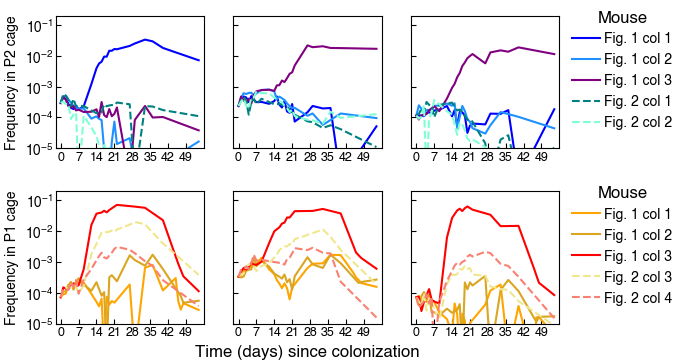

In [4]:
###  plot a few "locally adapted" examples
reload(shared)
mouse_colors = {1:'blue', 2:'dodgerblue', 3:'purple', 4:'teal', 5:'aquamarine',  8:'orange', 9:'goldenrod', 10:'red', 6:'khaki', 7:'salmon'}
relabel_mice = {1:'Fig. 1 col 1', 2:'Fig. 1 col 2', 3:'Fig. 1 col 3', 4:'Fig. 2 col 1', 5:'Fig. 2 col 2', 
                8:'Fig. 1 col 1', 9:'Fig. 1 col 2', 10:'Fig. 1 col 3', 6:'Fig. 2 col 3', 7:'Fig. 2 col 4'}
P2_examples = ['AACCTAATTGTACCGGTCCG', 'GGTACGAACGGTAACCCAGA', 'TAAGTACTTGGCGATTTTCT']
P1_examples = ['ACAAACATATCAGTGCTCTC', 'TGCGCACAGTGGTCACTCTC', 'TATGTTAGATAGGGATAAAC']

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure(figsize=(6.5,4))
gs = plt.GridSpec(3, 3, height_ratios=(1, 0.05, 1))

for row, (mice, examples, cage) in enumerate(zip([[1,2,3,4,5], [8,9,10,6,7]], [P2_examples, P1_examples], ['P2 cage', 'P1 cage'])):
    for col, example_bc in enumerate(examples):
        ax = fig.add_subplot(gs[2*row, col])
        bc_index = np.where(shared.barcodes == example_bc)[0][0]

        for mouse in mice:
            ls = 'solid'
            if mouse in [4,5,6,7]:
                ls = '--'

            days, reads, depths = shared.get_mouse_timecourse(expt, mouse)
            freqs = shared.calc_freqs(reads, depths)

            ax.plot(days, freqs[:, bc_index] + 1e-6, label=f'{relabel_mice[mouse]}', color=mouse_colors[mouse], ls=ls, lw=1.5)
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 2e-1)
        ax.set_xlim(-2, 56)
        ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
        ax.set_xticklabels([0, 7, 14, 21, 28, 35, 42, 49], fontsize=9)
        ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
        if col > 0:
            ax.set_yticklabels([])
        if col == 0:
            ax.set_ylabel(f'Frequency in {cage}', fontsize=10)
        if row == 1 and col == 1:
            ax.set_xlabel(f'Time (days) since colonization', fontsize=12)

        if col == 2:
            ax.legend(loc=(1.05, 0.1), ncol=1, title='Mouse', title_fontsize=12, fontsize=10, frameon=False, bbox_transform=ax.transAxes, handletextpad=0.3, columnspacing=1.0)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_monocolonization_locally_adapted_example.pdf', bbox_inches='tight', transparent=True)
fig.savefig(f'../figures/sfig_monocolonization_locally_adapted_example.svg', bbox_inches='tight', transparent=True)

In [16]:
np.sum(shared.vivo_array[0] / shared.vivo_depths[0][0] > 0)
np.sum(shared.vivo_array[1] / shared.vivo_depths[1][0] > 0)


20304

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28710/1392198980.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28710/1392198980.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


129 barcodes above 0.0001 in 1  at final timepoint
147 barcodes above 0.0001 in 2  at final timepoint
101 barcodes above 0.0001 in 3  at final timepoint
81 barcodes above 0.0001 in 8  at final timepoint


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28710/1392198980.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


69 barcodes above 0.0001 in 9  at final timepoint
48 barcodes above 0.0001 in 10  at final timepoint
73 barcodes above 0.0001 in 11  at final timepoint
93 barcodes above 0.0001 in 12  at final timepoint
77 barcodes above 0.0001 in 13  at final timepoint


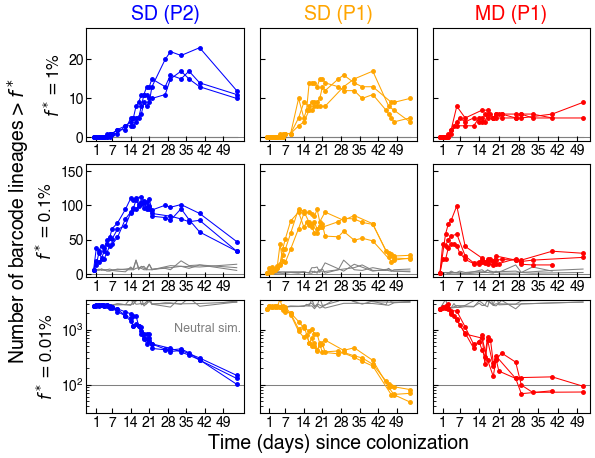

In [26]:
# reload(shared)
## barcodes at >x% frequency
fig = plt.figure(figsize=(6.5, 5))
gs = plt.GridSpec(3,3, figure=fig, wspace=0.1)
outer_ax = fig.add_subplot(gs[:, :])
util.turn_off_ax(outer_ax)
outer_ax.set_ylabel(r'Number of barcode lineages > $f^*$', fontsize=14, labelpad=40)
outer_ax.set_xlabel(r'Time (days) since colonization', fontsize=14, labelpad=15)
                 
expt = 'E1'
# print( [ (mouse, (shared.freq_array[shared.mouse_meta[expt][mouse][1][-1]] > shared.Deff_array[shared.mouse_meta[expt][mouse][1][-1]]**-1.).sum(),shared.Deff_array[shared.mouse_meta[expt][mouse][1][-1]]**-1.) for mouse in range(1, 14)]  )
Ntau = 10**6

barcodes_above_1e4 = {}
null_barcodes_above_1e4 = {}
final_freqs_above_1e4 = []

axs = [[],[],[]]


for row, (cutoff, cutoff_label) in enumerate(zip([1e-2, 1e-3, 1e-4], ['1%', '0.1%', '0.01%'])):
    for col, (mice, label, color) in enumerate(zip([[1,2,3], [8,9,10], [11, 12, 13]],
                                                   ['SD (P2)', 'SD (P1)', 'MD (P1)'],
                                                   ['blue', 'orange', 'red'])):
        ax = fig.add_subplot(gs[row, col])
        axs[row].append(ax)

        min_depth = np.min([10**4, 3*cutoff**-1.])
        for mouse in mice:
            if row == 2:# and mouse in [11,12,13]:
                days, reads, depths = shared.get_mouse_timecourse(expt, mouse, min_depth=min_depth)
                freqs = shared.calc_freqs(reads, depths)
                final_freqs = freqs[-1]
                barcodes_above = np.where(final_freqs > cutoff)[0]
                final_freqs_above_1e4.append((freqs[0, barcodes_above], freqs[0]))
                for bc in barcodes_above:
                    if bc not in barcodes_above_1e4:
                        barcodes_above_1e4[bc] = []
                    barcodes_above_1e4[bc].append(mouse)

                    null_bc = rnd.choice(np.arange(len(shared.barcodes)))
                    if null_bc not in null_barcodes_above_1e4:
                        null_barcodes_above_1e4[null_bc] = []
                    null_barcodes_above_1e4[null_bc].append(mouse)

                    
                print(len(barcodes_above), 'barcodes above', cutoff, 'in', mouse, ' at final timepoint')

            days, n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff('E1', mouse, cutoff, min_depth = min_depth)
            ax.plot(days, n_barcodes_above_cutoff, marker='.', color=color, markersize=5)
            sim_days, sim_n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff_simulated('E1', mouse, cutoff, Ntau=Ntau, min_depth=min_depth)
            ax.plot(sim_days, sim_n_barcodes_above_cutoff, color='grey', zorder=0)

        if row == 0: 
            ax.set_title(label, color=color, fontsize=14)
        if col == 0:
            ax.set_ylabel(r'$f^*=$' + f'{cutoff_label}', fontsize=12)

        ax.set_xticks([1, 7, 14, 21, 28, 35, 42, 49])
        ax.set_xticklabels([1, 7, 14, 21, 28, 35, 42, 49], fontsize=10)

        if row == 2:
            ax.set_ylim(30, 3500)
            # ax.set_yticks([100]+list(ax.get_yticks()))
            # ax.set_yticks([1, 100, 1000, 2000, 3000])
            ax.axhline(100, color='grey', zorder=0)
            ax.set_yscale('log')
        if row == 1:
            ax.set_ylim(-5, 160)
            ax.axhline(0, color='grey', zorder=0)
        if row == 0:
            ax.set_ylim(-1, 28)
            ax.axhline(0, color='grey', zorder=0)
        if col != 0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

        if row == 2 and col == 0:
            ax.text(0.98, 0.8, 'Neutral sim.', transform=ax.transAxes, color='grey', fontsize=9, ha='right', va='top')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_E1_mono_num_barcodes_above_cutoff.pdf', bbox_inches='tight', transparent=True)
fig.savefig(f'../figures/sfig_E1_mono_num_barcodes_above_cutoff.svg', bbox_inches='tight', transparent=True)

In [27]:
n_mice_deteceted = [len(barcodes_above_1e4[bc]) for bc in barcodes_above_1e4]
x = np.bincount(n_mice_deteceted)
print(x)

print( np.sum(x[2:]))
print( np.sum(x[2:]) / np.sum(x) )


n_mice_deteceted = [len(null_barcodes_above_1e4[bc]) for bc in null_barcodes_above_1e4]
x = np.bincount(n_mice_deteceted)
print(x)

print( np.sum(x[2:]) / np.sum(x) )



[  0 314  83  98   3   2   1   1   0   1]
189
0.3757455268389662
[  0 806   6]
0.007389162561576354


KstestResult(statistic=0.7285928575554914, pvalue=2.3991944001454863e-70, statistic_location=7.839685971215868e-06, statistic_sign=1)
KstestResult(statistic=0.7299922581507472, pvalue=1.8190567817569194e-80, statistic_location=7.549327231541204e-06, statistic_sign=1)
KstestResult(statistic=0.6693726329400694, pvalue=3.7281790550068014e-45, statistic_location=1.1469170217149137e-05, statistic_sign=1)
KstestResult(statistic=0.7001462373569489, pvalue=2.5037321896954733e-40, statistic_location=9.503754527524308e-06, statistic_sign=1)
KstestResult(statistic=0.7249686679239626, pvalue=2.0499117220179127e-37, statistic_location=2.6135324950691853e-05, statistic_sign=1)
KstestResult(statistic=0.7807577782325865, pvalue=1.7482362528981957e-31, statistic_location=2.0393473256979246e-05, statistic_sign=1)
KstestResult(statistic=0.7012864801910548, pvalue=1.5476751270062846e-36, statistic_location=2.4551365862771136e-05, statistic_sign=1)
KstestResult(statistic=0.6476239889944917, pvalue=1.357718

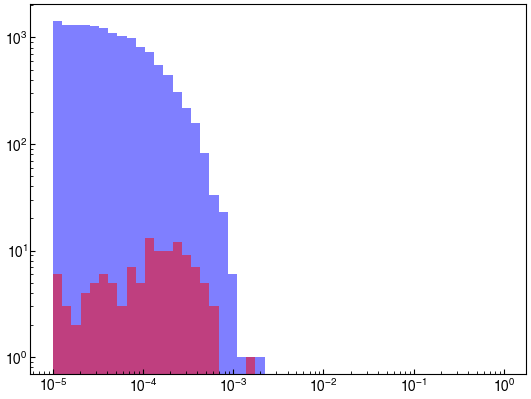

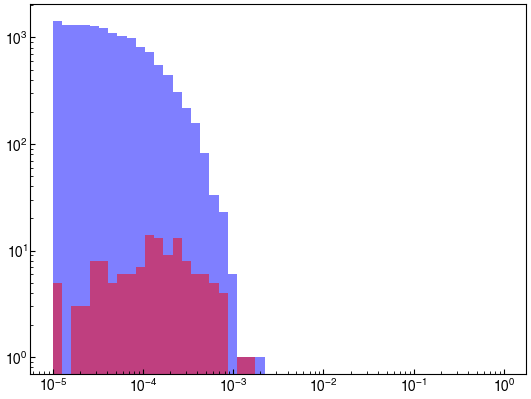

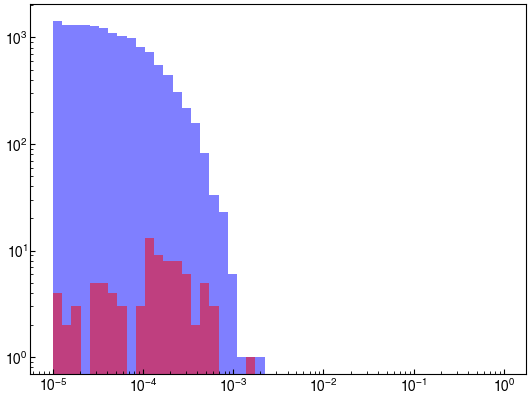

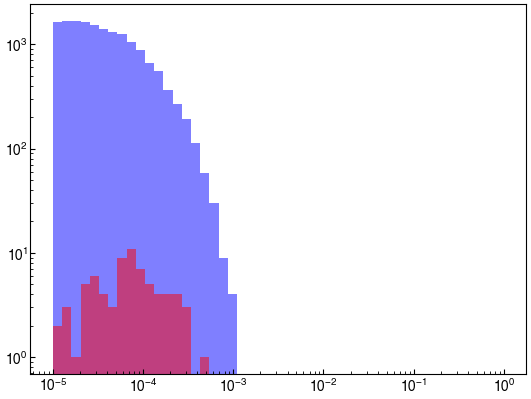

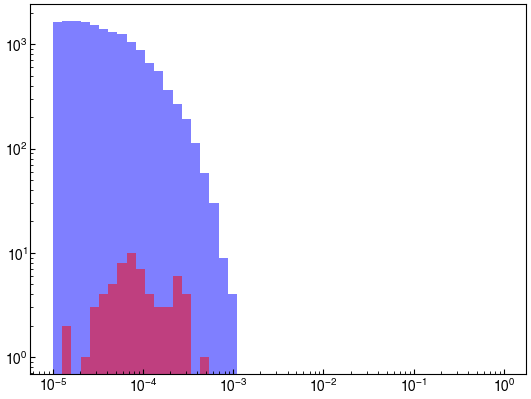

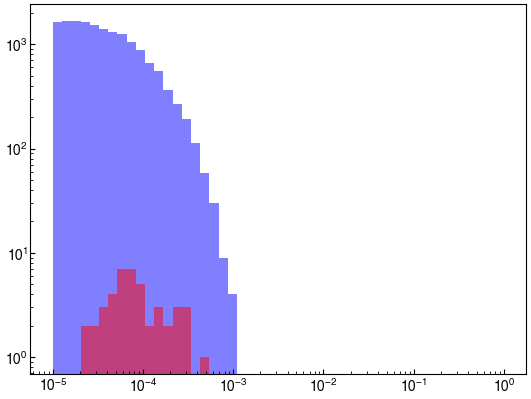

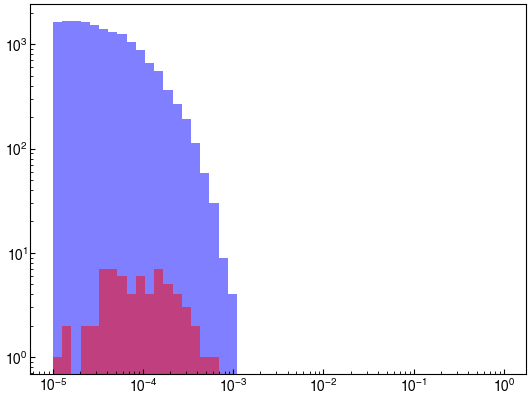

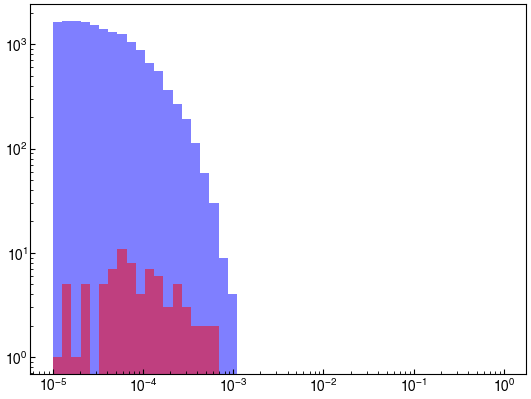

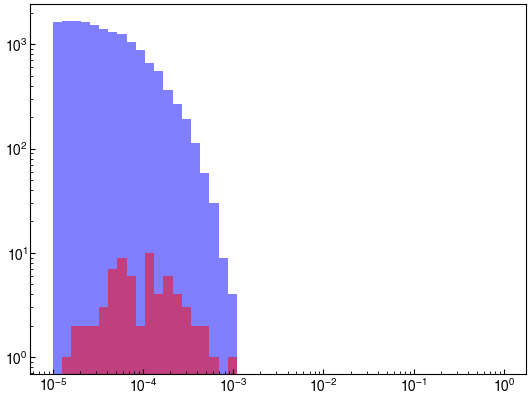

In [22]:
for (init_freqs_final_conditioned, init_freqs) in final_freqs_above_1e4:
    print( scipy.stats.kstest(init_freqs, init_freqs_final_conditioned) )
    fig, ax = plt.subplots()
    ax.hist(init_freqs, bins=np.logspace(-5, 0, 50), alpha=0.5, color='blue', label='Initial')
    ax.hist(init_freqs_final_conditioned, bins=np.logspace(-5, 0, 50), alpha=0.5, color='red', label='Final')
    ax.set_xscale('log')
    ax.set_yscale('log')


In [46]:
n_mice_deteceted = [len(barcodes_above_1e4[bc]) for bc in barcodes_above_1e4]
x = np.bincount(n_mice_deteceted)
print(x)

print( np.sum(x[2:]) / np.sum(x) )


[ 0 57 12 39]
0.4722222222222222


In [44]:
n_mice_deteceted = [len(barcodes_above_1e4[bc]) for bc in barcodes_above_1e4]
x = np.bincount(n_mice_deteceted)
print(x)

print( np.sum(x[2:]) / np.sum(x) )


[  0 169  38  44]
0.32669322709163345
